In [1]:
import json
import collections
import matplotlib.pyplot as plt
import numpy as np
import re
import csv
import pandas as pd
import nltk
from sklearn import preprocessing
import time
from datetime import datetime
from datetime import timedelta

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [13]:
def merge_data(baseline_dir = 'data/baseline_data2.csv', 
               senti_dir = 'data/sentimentAnalysis/senti.csv', 
               spx_dir = 'data/all_cleaned_SPX_data.csv', 
               threshold = 1e-4, 
               m = 5,
              text_included = False):
    
    df1= pd.read_csv(baseline_dir)
    senti_data = pd.read_csv(senti_dir)
    df2 = senti_data[['time', 'positive_count', 'negative_count']]
    df = pd.merge(df1, df2, left_on = 'created_time', right_on='time').drop(['time'], axis=1)
    
    df['created_time'] = df['created_time'].apply(lambda x: pd.to_datetime(x))
    df['begin_time'] = df['created_time'].dt.floor('1min')
    df['end_time'] = df['begin_time'] + timedelta(minutes=m)
    
    data_econ = pd.read_csv('data/all_cleaned_SPX_data.csv')
    data_econ['datetime'] = pd.to_datetime(data_econ['datetime'], utc = True)
    df_econ = data_econ[['datetime', 'close']]
    
    df_merge1 = pd.merge(df, df_econ, left_on = 'begin_time', right_on='datetime').drop(['datetime'], axis=1)
    df_merge2 = pd.merge(df_merge1, df_econ, left_on = 'end_time', right_on='datetime').drop(['datetime'], axis=1)
    
    df_merge2['label'] = np.where(df_merge2['close_y'] > df_merge2['close_x'], 1, -1)
    medium1 = df_merge2['close_y'] / df_merge2['close_x'] > (1-threshold)
    medium2 = df_merge2['close_y'] / df_merge2['close_x'] < (1+threshold)
    medium = medium1 & medium2
    df_merge2['label'][medium] = 0
    
    if text_included:
        df_all = df_merge2.drop(['created_time','begin_time','end_time', 'close_x','close_y'], axis=1)
    else:
        df_all = df_merge2.drop(['created_time','begin_time','end_time', 'close_x','close_y','texts'], axis=1)

    df_all['retweet'] = np.where(df_all['favorite_count'] == 0, 1, 0)

    return df_all
    

In [4]:
df_all = merge_data(threshold=0, m = 5)
df_all.head()

C:\Users\for_y\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,favorite_count,retweet_count,china,billion,products,democrats,great,dollars,tariffs,country,...,party,years,farmers,going,trade,never,positive_count,negative_count,label,retweet
0,114187,20211,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,72619,18328,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,3,-1,0
2,83333,24007,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,4,1,0
3,65540,14962,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,132078,35482,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,2,-1,0


In [5]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test =train_test_split(df_all.loc[:, df_all.columns != 'label'], 
                                                     df_all.label, test_size=0.2)

scores = {}
min_max_scaler = MinMaxScaler().fit(X_train)
xtrain_scaled = min_max_scaler.transform(X_train.values)
xtest_scaled = min_max_scaler.transform(X_test.values)
X_train_scaled = pd.DataFrame(xtrain_scaled, columns = X_train.columns, index = X_train.index)
X_test_scaled = pd.DataFrame(xtest_scaled, columns = X_test.columns, index = X_test.index)

rf = RandomForestClassifier(max_depth=20, n_estimators=1000)
rf.fit(X_train_scaled,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Feature ranking for randomforest:
1. feature retweet_count (0.343987)
2. feature favorite_count (0.288717)
3. feature positive_count (0.097044)
4. feature negative_count (0.082156)
5. feature great (0.024202)
6. feature president (0.022049)
7. feature people (0.021058)
8. feature country (0.019109)
9. feature never (0.015959)
10. feature going (0.014995)


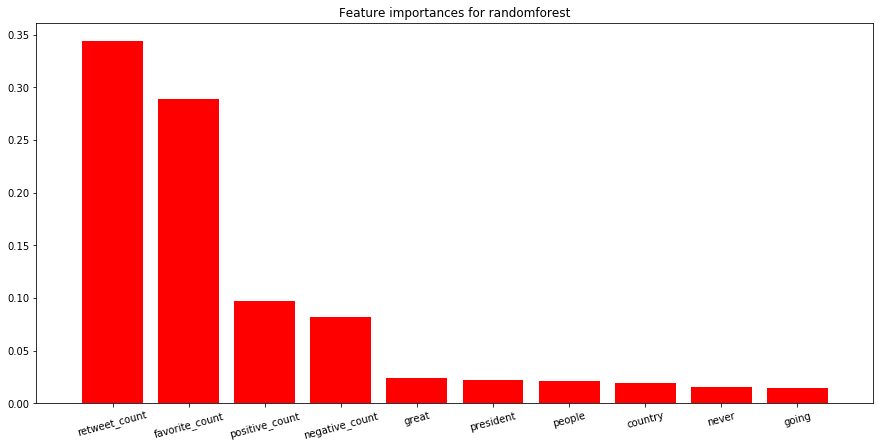

In [12]:
def feature_importance(model, ax, name):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    print("Feature ranking for {}:".format(name))
    for f in range(10):
        print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

    ax.set_title("Feature importances for {}".format(name))
    ax.bar(range(len(indices)), importances[indices],
           color="r", align="center")
    ax.set_xticks(np.arange(len(indices)))
    ax.set_xticklabels(X_train.columns[indices], rotation = 15)
    ax.set_xlim([-1, len(indices)])

fig, ax = plt.subplots(1, 1, figsize = (15,7))
feature_importance(rf, ax, "randomforest")

In [94]:
# see impact of all the words

JPmorgan_words = ["china", "billion", "products", "democrats", "great","dollars","tariffs","country", "mueller","border",\
                     "president", "congressman", "people", "korea", "party", "years", "farmers", "going", "trade", "never"]

df_all = merge_data(threshold=0, m = 5, text_included=True)

C:\Users\for_y\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [95]:
df_all = df_all.drop(JPmorgan_words,axis = 1)
df_all.head()

,favorite_count,retweet_count,texts,positive_count,negative_count,label,retweet
0,114187,20211,stock market big today new record enjoy,1,0,1,0
1,72619,18328,radical left dems lamestream medium trying mak...,1,3,-1,0
2,83333,24007,amazon washington post three lowlife reporter ...,1,4,1,0
3,65540,14962,thank #MAGA,1,0,1,0
4,132078,35482,explained next week fake hearing trial house i...,0,2,-1,0


In [96]:
df_all = df_all.dropna()

from collections import Counter
c = Counter(df_all['texts'].apply(lambda x: x.split()).sum())

In [97]:
words = sorted(c.items(), key = lambda x: x[1], reverse = True)[:1000]
words = [word[0] for word in words if len(word[0]) >=5]

for word in words:
    df_all[word] = df_all['texts'].apply(lambda x: 1 if word in x else 0)

In [98]:
df_all = df_all.drop(['texts', 'favorite_count', 'retweet_count','positive_count','negative_count','retweet'],axis = 1)
print(df_all.shape)

(9532, 687)


In [99]:
X_train, X_test, y_train, y_test =train_test_split(df_all.loc[:, df_all.columns != 'label'], 
                                                     df_all.label, test_size=0.2)

scores = {}
min_max_scaler = MinMaxScaler().fit(X_train)
xtrain_scaled = min_max_scaler.transform(X_train.values)
xtest_scaled = min_max_scaler.transform(X_test.values)
X_train_scaled = pd.DataFrame(xtrain_scaled, columns = X_train.columns, index = X_train.index)
X_test_scaled = pd.DataFrame(xtest_scaled, columns = X_test.columns, index = X_test.index)

rf = RandomForestClassifier(max_depth=20, n_estimators=1000)
rf.fit(X_train_scaled,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [100]:
rf.score(xtest_scaled, y_test)

0.5369690613529103

Feature ranking for randomforest:
1. feature wealth (0.010363)
2. feature great (0.008362)
3. feature country (0.008097)
4. feature trump (0.007015)
5. feature harassment (0.006576)
6. feature president (0.006358)
7. feature thing (0.006339)
8. feature losing (0.006126)
9. feature state (0.005648)
10. feature people (0.005552)
11. feature thank (0.005329)
12. feature unemployment (0.005266)
13. feature event (0.005170)
14. feature america (0.005146)
15. feature never (0.005072)
16. feature china (0.004949)
17. feature witch (0.004913)
18. feature released (0.004788)
19. feature twitter (0.004783)
20. feature nation (0.004751)


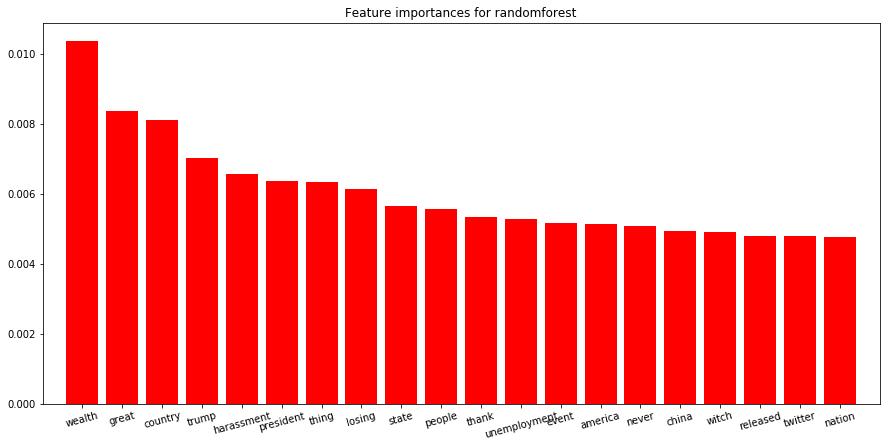

In [101]:
def feature_importance(model, ax, name):
    importances = model.feature_importances_
    size = 20
    indices = np.argsort(importances)[::-1][:size]
    top_20_words = []
    print("Feature ranking for {}:".format(name))
    for f in range(size):
        top_20_words.append(X_train.columns[indices[f]])
        print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

    ax.set_title("Feature importances for {}".format(name))
    ax.bar(range(len(indices)), importances[indices],
           color="r", align="center")
    ax.set_xticks(np.arange(len(indices)))
    ax.set_xticklabels(X_train.columns[indices], rotation = 15)
    ax.set_xlim([-1, len(indices)])
    return top_20_words

fig, ax = plt.subplots(1, 1, figsize = (15,7))
top_20_word = feature_importance(rf, ax, "randomforest")

In [102]:
top_20_word

['wealth',
 'great',
 'country',
 'trump',
 'harassment',
 'president',
 'thing',
 'losing',
 'state',
 'people',
 'thank',
 'unemployment',
 'event',
 'america',
 'never',
 'china',
 'witch',
 'released',
 'twitter',
 'nation']